In [10]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
%matplotlib inline

tf.__version__

'1.13.1'

## "Predict Bitcoin Prices"

Adapted from [this post](https://hackernoon.com/dont-be-fooled-deceptive-cryptocurrency-price-predictions-using-deep-learning-bf27e4837151)

In [0]:
sendpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

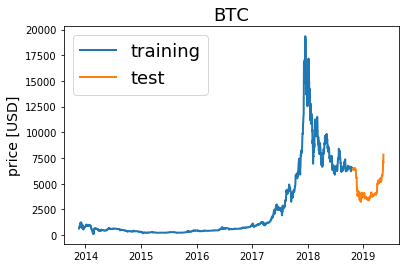

In [4]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1)
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.close, test.close, 'training', 'test', 'BTC')

In [0]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1
def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test
train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [11]:
def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model
model = build_lstm_model(X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1794/1794 [==============================] - 3s 2ms/sample - loss: 0.0627
Epoch 2/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0470
Epoch 3/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0414
Epoch 4/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0388
Epoch 5/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0379
Epoch 6/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0362
Epoch 7/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0362
Epoch 8/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0356
Epoch 9/50
1794/1794 [==============================] - 2s 1ms/sample - loss: 0.0347


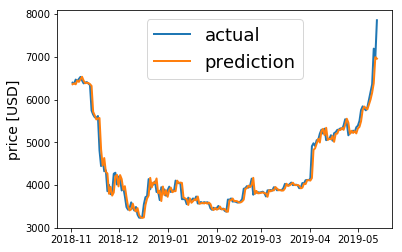

In [22]:
target_col = "close"
window_len = 7
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
# convert change predictions back to actual price
preds = test.close.values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction')

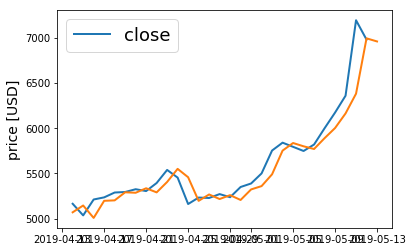

In [24]:
n = 30
line_plot(targets[-n:][:-1], preds[-n:])